<a href="https://colab.research.google.com/github/juliuswiscmsba/NLP-Disaster-Tweets/blob/main/Disaster_Tweets_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from tensorflow.python.keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split 
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score


In [2]:
from google.colab import files
train_clean = files.upload()
test_clean = files.upload()

Saving train_clean.csv to train_clean.csv


Saving test_clean.csv to test_clean.csv


In [3]:
train = pd.read_csv("train_clean.csv")
test = pd.read_csv("test_clean.csv")

In [4]:
train.head()

,id,keyword,location,text,target,word_count
0,1,Unknown,Unknown,deed reason earthquake may allah forgive u,1,13
1,4,Unknown,Unknown,forest fire near la ronge sask canada,1,7
2,5,Unknown,Unknown,resident asked shelter place notified officer ...,1,22
3,6,Unknown,Unknown,13 000 people receive wildfire evacuation orde...,1,8
4,7,Unknown,Unknown,got sent photo ruby alaska smoke wildfire pour...,1,16


In [5]:
X = train.text
y = train.target

In [6]:
#split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.1, random_state = 42)

In [9]:
#define the LSTM model
def LSTM_model():
    model = tf.keras.Sequential([
        Input(name='inputs',shape=[50]),
        Embedding(len(tok.word_index), 32),
        Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)),
        Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.1)),
        Bidirectional(tf.keras.layers.LSTM(128)),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    #compile model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(5e-5),
                  metrics=['accuracy'])
    
    return model

In [11]:
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
train_sequences = tok.texts_to_sequences(X_train)
val_sequences = tok.texts_to_sequences(X_val)
test_sequences = tok.texts_to_sequences(X_test)

#padded sequences
X_train_seq = pad_sequences(train_sequences,maxlen=50)
X_val_seq = pad_sequences(val_sequences,maxlen=50)
X_test_seq = pad_sequences(test_sequences,maxlen=50)

model = LSTM_model()
history = model.fit(X_train_seq, y_train, epochs=20,
                    validation_data =(X_val_seq, y_val), batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=10, restore_best_weights=True)])

Epoch 1/20
172/172 [==============================] - 16s 40ms/step - loss: 0.6862 - accuracy: 0.5610 - val_loss: 0.6811 - val_accuracy: 0.5698
Epoch 2/20
172/172 [==============================] - 4s 25ms/step - loss: 0.6774 - accuracy: 0.5703 - val_loss: 0.6714 - val_accuracy: 0.5698
Epoch 3/20
172/172 [==============================] - 4s 25ms/step - loss: 0.6342 - accuracy: 0.6453 - val_loss: 0.6063 - val_accuracy: 0.6814
Epoch 4/20
172/172 [==============================] - 5s 29ms/step - loss: 0.4718 - accuracy: 0.7847 - val_loss: 0.5171 - val_accuracy: 0.7504
Epoch 5/20
172/172 [==============================] - 5s 27ms/step - loss: 0.3537 - accuracy: 0.8535 - val_loss: 0.5086 - val_accuracy: 0.7750
Epoch 6/20
172/172 [==============================] - 4s 25ms/step - loss: 0.2964 - accuracy: 0.8843 - val_loss: 0.4982 - val_accuracy: 0.7767
Epoch 7/20
172/172 [==============================] - 4s 26ms/step - loss: 0.2604 - accuracy: 0.8991 - val_loss: 0.5362 - val_accuracy: 0.778

In [12]:
yhat = np.where(model.predict(X_test_seq) >=0.5,1,0)

In [13]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.82      0.68      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



Text(51.0, 0.5, 'Real')

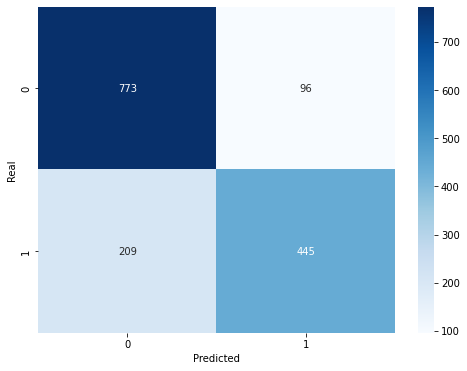

In [14]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,yhat), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Real')

In [15]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

X_test = test['text']

y_test_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold+1},", end=' ')
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    
    
    #define Keras Tokenizer
    tok = Tokenizer()
    tok.fit_on_texts(X_train)

    #return sequences
    train_sequences = tok.texts_to_sequences(X_train)
    val_sequences = tok.texts_to_sequences(X_val)
    test_sequences = tok.texts_to_sequences(X_test)

    #padded sequences
    X_train_seq = pad_sequences(train_sequences,maxlen=50)
    X_val_seq = pad_sequences(val_sequences,maxlen=50)
    X_test_seq = pad_sequences(test_sequences,maxlen=50)
    
    #create the model
    model = LSTM_model()
    #fit the model
    history = model.fit(X_train_seq, y_train, epochs=20,
                    validation_data =(X_val_seq, y_val), batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', 
                    patience=3, verbose=False, restore_best_weights=True)])


    yhat_val =  np.where(model.predict(X_val_seq) >=0.5,1,0)
    
    f_score = f1_score(y_val,yhat_val)
    print('F1 Score: ' + str(f_score))
    print(classification_report(y_val,yhat_val))
    
    y_test_list.append(model.predict(X_test_seq))

    
print('Done...')

Fold: 1, Epoch 1/20
191/191 [==============================] - 16s 38ms/step - loss: 0.6851 - accuracy: 0.5704 - val_loss: 0.6794 - val_accuracy: 0.5699
Epoch 2/20
191/191 [==============================] - 6s 29ms/step - loss: 0.6756 - accuracy: 0.5704 - val_loss: 0.6610 - val_accuracy: 0.5699
Epoch 3/20
191/191 [==============================] - 5s 27ms/step - loss: 0.5915 - accuracy: 0.6933 - val_loss: 0.5032 - val_accuracy: 0.7682
Epoch 4/20
191/191 [==============================] - 5s 27ms/step - loss: 0.4178 - accuracy: 0.8189 - val_loss: 0.4838 - val_accuracy: 0.7853
Epoch 5/20
191/191 [==============================] - 5s 26ms/step - loss: 0.3355 - accuracy: 0.8594 - val_loss: 0.4920 - val_accuracy: 0.7971
Epoch 6/20
191/191 [==============================] - 5s 27ms/step - loss: 0.2918 - accuracy: 0.8805 - val_loss: 0.4939 - val_accuracy: 0.8030
Epoch 7/20
191/191 [==============================] - 5s 26ms/step - loss: 0.2542 - accuracy: 0.9000 - val_loss: 0.4856 - val_accura

In [16]:
#Store prediction to the submission file
test['target'] = np.where(np.mean(y_test_list, axis = 0) >=0.5, 1,0)
sub = test[['id','target']].copy()
sub.to_csv('submission_lstm.csv', index = False)
files.download('submission_lstm.csv')
#Result: 0.79865

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>